In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt

from matplotlib_venn import venn2
import itertools as itt
from collections import defaultdict
import logging
import pybel
from pybel.constants import *
from pybel.canonicalize import calculate_canonical_name
import pybel_tools as pbt
from pybel_tools.visualization import to_jupyter
import pybel_tools.analysis.npa as npa

import seaborn as sns

#%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
pybel.__version__

'0.4.1'

In [3]:
pbt.__version__

'0.1.3-dev'

In [4]:
bms_base = os.environ['BMS_BASE']
owncloud_base = os.environ['OWNCLOUD_BASE']

## Load

In [5]:
pickle_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.gpickle')

In [6]:
graph = pybel.from_pickle(pickle_path)

## Canonical Mechanisms

In [7]:
canonical_mechanism_names = pbt.summary.get_annotation_values(graph, 'Subgraph')
canonical_mechanism_names 

{'AD T2DM SNPs',
 'ADAM Metallopeptidase subgraph',
 'ATP binding cassette transport subgraph',
 'Acetylcholine signaling subgraph',
 'Akt subgraph',
 'Albumin subgraph',
 'Alcohol dehydrogenase subgraph',
 'Alpha 2 macroglobulin subgraph',
 'Amylin subgraph',
 'Amyloidogenic subgraph',
 'Androgen subgraph',
 'ApoE subgraph',
 'Apoptosis signaling subgraph',
 'Autophagy signaling subgraph',
 'Axonal guidance subgraph',
 'Axonal transport subgraph',
 'Bcl-2 subgraph',
 'Beta secretase subgraph',
 'Beta-Catenin subgraph',
 'Beta-Oxidation of Fatty Acids',
 'Binding and Uptake of Ligands by Scavenger Receptors',
 'Blood vessel dilation subgraph',
 'CREB subgraph',
 'CRH subgraph',
 'Calcium-dependent signal transduction',
 'Calpastatin-calpain subgraph',
 'Calsyntenin subgraph',
 'Caspase subgraph',
 'Cell adhesion subgraph',
 'Cell cycle subgraph',
 'Cell-cell communication subgraph',
 'Chaperone subgraph',
 'Chemokine signaling subgraph',
 'Cholesterol metabolism subgraph',
 'Complement

In [8]:
%%time
canonical_mechanisms = {}
for sg in canonical_mechanism_names:
    m = pbt.selection.get_subgraph_by_annotation(graph, sg)
    canonical_mechanisms[sg] = m

CPU times: user 13.6 s, sys: 43 ms, total: 13.7 s
Wall time: 13.7 s


## Generated Mechanisms

In [9]:
bioprocess_nodes = list(pbt.selection.get_nodes_by_function(graph, BIOPROCESS))
len(bioprocess_nodes)

440

In [10]:
%%time
candidate_mechanisms = {}
for bp in bioprocess_nodes:
    m = pbt.generation.generate_mechanism(graph, bp)
    candidate_mechanisms[bp] = m

CPU times: user 3.11 s, sys: 23.8 ms, total: 3.13 s
Wall time: 3.14 s


## Comparison

In [11]:
%%time

results = defaultdict(dict)

for candidate, canonical in itt.product(sorted(candidate_mechanisms), sorted(canonical_mechanisms)):
    candidate_nodes = set(candidate_mechanisms[candidate].nodes_iter())
    canonical_nodes = set(canonical_mechanisms[canonical].nodes_iter())
    tanimoto = pbt.utils.tanimoto_set_similarity(candidate_nodes, canonical_nodes)
    results[canonical][candidate] = tanimoto

df = pd.DataFrame(results)

CPU times: user 4.03 s, sys: 13.1 ms, total: 4.04 s
Wall time: 4.04 s


In [12]:
df.head()

BiologicalProcess  \
                                                      ADO   
                                         loss_of_synapses   
AD T2DM SNPs                                          0.0   
ADAM Metallopeptidase subgraph                        0.0   
ATP binding cassette transport subgraph               0.0   
Acetylcholine signaling subgraph                      0.0   
Akt subgraph                                          0.0   

                                                                  \
                                                            GOBP   
                                        ATP biosynthetic process   
AD T2DM SNPs                                            0.000000   
ADAM Metallopeptidase subgraph                          0.033898   
ATP binding cassette transport subgraph                 0.037500   
Acetylcholine signaling subgraph                        0.013889   
Akt subgraph                                            0.022222   

                                                                \
                                                                 
                                        B cell differentiation   
AD T2DM SNPs                                               0.0   
ADAM Metallopeptidase subgraph                             0.0   
ATP binding cassette transport subgraph                    0.0   
Acetylcholine signaling subgraph                           0.0   
Akt subgraph                                               0.0   

                                                                                    \
                                                                                     
                                        CD8-positive, alpha-beta T cell activation   
AD T2DM SNPs                                                                   0.0   
ADAM Metallopeptidase subgraph                                                 0.0   
ATP binding cassette transport subgraph                                        0.0   
Acetylcholine signaling subgraph                                               0.0   
Akt subgraph                                                                   0.0   

                                                                  \
                                                                   
                                        DNA biosynthetic process   
AD T2DM SNPs                                            0.023810   
ADAM Metallopeptidase subgraph                          0.080357   
ATP binding cassette transport subgraph                 0.028777   
Acetylcholine signaling subgraph                        0.045685   
Akt subgraph                                            0.048276   

                                                                              \
                                                                               
                                        DNA synthesis involved in DNA repair   
AD T2DM SNPs                                                             0.0   
ADAM Metallopeptidase subgraph                                           0.0   
ATP binding cassette transport subgraph                                  0.0   
Acetylcholine signaling subgraph                                         0.0   
Akt subgraph                                                             0.0   

                                                                           \
                                                                            
                                        ERK1 and ERK2 cascade JNK cascade   
AD T2DM SNPs                                         0.000000         0.0   
ADAM Metallopeptidase subgraph                       0.000000         0.0   
ATP binding cassette transport subgraph              0.000000         0.0   
Acetylcholine signaling subgraph                     0.007143         0.0   
Akt subgraph                                         0.000000  

In [14]:
df.to_csv(os.path.expanduser('~/Desktop/subgraph_comparison.csv'))

RuntimeError: LaTeX was not able to process the following string:
b'BiologicalProcess-PTS-Wnt/beta_catenin pathway'
Here is the full report generated by LaTeX: 

This is pdfTeX, Version 3.14159265-2.6-1.40.17 (TeX Live 2016) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./9f4777df0279847d005f816a3e21a416.tex
LaTeX2e <2016/03/31>
Babel <3.9r> and hyphenation patterns for 83 language(s) loaded.
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2016/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2016/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2016/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2016/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2016/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2016/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file 9f4777df0279847d005f816a3e21a416.aux.
(/usr/local/texlive/2016/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.12 ...{\sffamily BiologicalProcess-PTS-Wnt/beta_
                                                  catenin pathway}
! Extra }, or forgotten $.
l.12 ...gicalProcess-PTS-Wnt/beta_catenin pathway}
                                                  
! Missing $ inserted.
<inserted text> 
                $
l.13 \end{document}
                   
[1] (./9f4777df0279847d005f816a3e21a416.aux) )
(\end occurred inside a group at level 1)

### simple group (level 1) entered at line 12 ({)
### bottom level
(see the transcript file for additional information)
Output written on 9f4777df0279847d005f816a3e21a416.dvi (1 page, 388 bytes).
Transcript written on 9f4777df0279847d005f816a3e21a416.log.


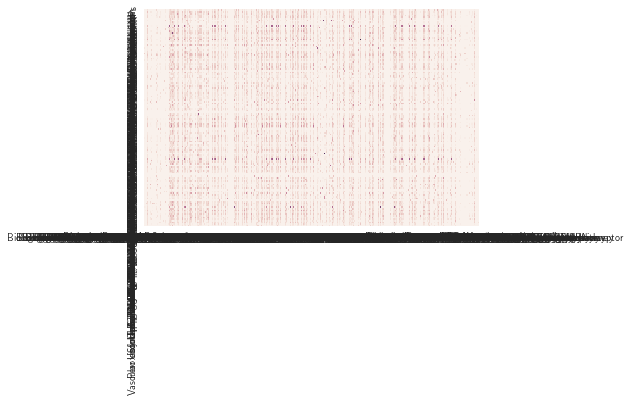

In [13]:
sns.heatmap(df)